In [1]:
import gym
import gym_game
import matplotlib.pyplot as plt
env = gym.make('Parkme')
reset, _ = env.reset()
n_actions = env.action_space.n
states_dim = env.observation_space.shape[0]
print(n_actions, states_dim)

5 7


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [2]:
from sklearn.neural_network import MLPClassifier
import pickle
def load_agent(path=None):
    if path is None:
        agent = MLPClassifier(
            hidden_layer_sizes=(16),
            activation='tanh',
        )
        return agent.partial_fit([reset] * n_actions, range(n_actions), range(n_actions))
    with open(path, 'rb') as model:
        return pickle.load(model)
agent = load_agent('CEM.pkl')

In [3]:
import numpy as np
def generate_session(env, agent):
    states, actions = [], []
    total_reward = 0
    s, _ = env.reset()
    while True:
        probs = agent.predict_proba([s])[0]
        action = np.random.choice(list(range(n_actions)), p = probs)    
        new_s, r, terminated, truncated, _ = env.step(action)
        states.append(s)
        actions.append(action)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions


In [5]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    plt.show()


mean reward = 3060.974, threshold=3251.324


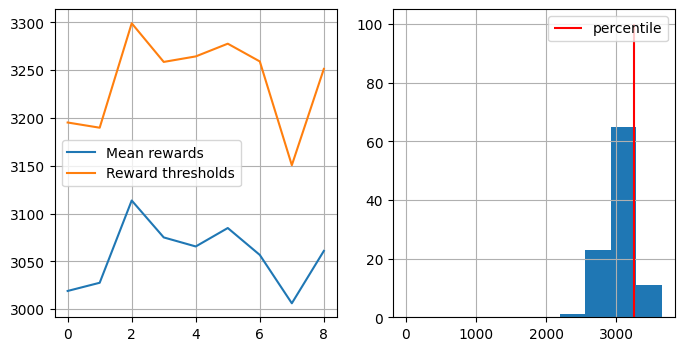

 90%|█████████ | 9/10 [12:07<01:21, 81.20s/it]

In [6]:
%%time
import tqdm as tqdm
percentile = 80
log = []
n_epochs = 10
best_reward = 0
for i in tqdm.tqdm(range(n_epochs)):
    sessions = [generate_session(env, agent) for _ in tqdm.tqdm(range(100))]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent = agent.partial_fit(elite_states, elite_actions)
    if np.mean(rewards_batch) > best_reward:
        with open('CEM.pkl', 'wb') as model:
            pickle.dump(agent, model)
        best_reward = np.mean(rewards_batch)
    show_progress(
        rewards_batch, log, percentile, reward_range=[0, max(0, np.max(rewards_batch))]
    )

In [ ]:
import pickle
with open('distance.pkl', 'wb') as file:
    pickle.dump(agent, file)